In [2]:
import numpy as np
import skvideo.io
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
plt.rcParams.update({'font.size': 42})
import os
import csv
import json
import re
import cv2
import json
import seaborn as sns
import pandas as pd

In [3]:
def read_dataset_csv(dataset_path, val_ways):
    def join_paths(class_index, phase_data):
        return os.path.join(dataset_path, "class_{}_{}.tfrecords".format(class_index, phase_data))

    dataset = pd.read_csv(os.path.join(dataset_path, "dataset_description.csv"))
    train_names = dataset["symbol"].values
    val_names = train_names.copy()
    train_num_samples = dataset["train_num_samples"].values
    val_samples = dataset["test_num_samples"].values
    train_indices = np.arange(len(train_names))
    # train data
    np.random.shuffle(train_indices)
    train_class_indices = train_indices[:-val_ways]
    train_class_names = train_names[train_class_indices]
    train_filenames = [join_paths(i, "train") for i in train_class_indices]

    val_class_indices = np.random.choice(train_class_indices, val_ways, replace=False)
    val_class_names = val_names[val_class_indices]
    val_num_samples = val_samples[val_class_indices]
    val_filenames = [join_paths(i, "test") for i in val_class_indices]
    num_val_samples = sum(val_num_samples)

    # test data
    test_class_indices = train_indices[-val_ways:]
    test_class_names = train_names[test_class_indices]
    test_filenames = [join_paths(i, "train") for i in test_class_indices]
    test_num_samples = train_num_samples[test_class_indices]
    num_test_samples = sum(test_num_samples)

    return train_class_names, val_class_names, test_class_names, train_filenames, val_filenames, \
           test_filenames, train_class_indices, val_class_indices, test_class_indices, \
           num_val_samples, num_test_samples

In [4]:
def parser(record, image_dims, resize_dims):
    """It parses one tfrecord entry

    Args:
        record: image + label
    """
    with tf.device('/cpu:0'):
        features = tf.parse_single_example(record,
                                           features={
                                               'height': tf.FixedLenFeature([], tf.int64),
                                               'width': tf.FixedLenFeature([], tf.int64),
                                               'depth': tf.FixedLenFeature([], tf.int64),
                                               'image_raw': tf.FixedLenFeature([], tf.string),
                                               'label': tf.FixedLenFeature([], tf.int64),
                                           })
        label = tf.cast(features["label"], tf.int32)
        image_shape = tf.stack(list(image_dims))
        image = tf.decode_raw(features["image_raw"], tf.uint8)
        image = tf.cast(image, tf.float16)
        image = tf.scalar_mul(1 / (2 ** 8), image)
        image = tf.reshape(image, image_shape)
    return image, label

In [5]:
def tfrecords_to_dataset(filenames, batch_size, im_size, shuffle, re_size=None):
    """ Starting from tfRecord files, it creates tensorflow datasets.
    """
    with tf.device('/cpu:0'):
        files = tf.data.Dataset.list_files(filenames)
        if shuffle:
            dataset = files.apply(tf.contrib.data.parallel_interleave(
                tf.data.TFRecordDataset, cycle_length=len(filenames),
                block_length=max(2, batch_size // 4)))
            dataset = dataset.shuffle(buffer_size=100000)
        else:
            dataset = files.apply(tf.contrib.data.parallel_interleave(
                tf.data.TFRecordDataset, cycle_length=len(filenames),
                block_length=max(2, batch_size // len(filenames))))

        dataset = dataset.apply(
            tf.contrib.data.map_and_batch(map_func=lambda x: parser(x, im_size,
                                                                    re_size),
                                          batch_size=batch_size,
                                          num_parallel_calls=4, drop_remainder=True))
        dataset.prefetch(buffer_size=batch_size * 10)
    return dataset

In [6]:
def deploy_dataset(filenames, batch_size, image_dims, shuffle):
    dataset = tfrecords_to_dataset(filenames, batch_size, image_dims, shuffle)
    iterator = dataset.make_initializable_iterator()
    image_batch, label_batch = iterator.get_next()
    labels_one_hot = tf.one_hot(label_batch, len(filenames))
    return iterator, image_batch, label_batch, labels_one_hot


In [7]:
train_class_names, val_class_names, test_class_names, \
train_filenames, val_filenames, test_filenames, \
train_class_indices, val_class_indices, test_class_indices, \
num_val_samples, num_test_samples = read_dataset_csv("/mnt/data/siamese_cluster_new/data/tiny-imagenet", 5)

In [8]:
train_filenames

['/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_172_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_195_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_121_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_83_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_185_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_104_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_55_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_139_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_180_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_72_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_159_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_91_train.tfrecords',
 '/mnt/data/siamese_cluster_new/data/tiny-imagenet/class

In [9]:
(train_iterator, train_image_batch,
 train_label_batch, _) = deploy_dataset(train_filenames,
                                        32, (64, 64, 3),
                                        True)
(val_iterator, val_image_batch,
 val_label_batch, _) = deploy_dataset(val_filenames,
                                      32, (64, 64, 3),
                                      False)

(test_iterator, test_image_batch,
 test_label_batch, _) = deploy_dataset(test_filenames,
                                      32, (64, 64, 3),
                                      False)

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.


In [10]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
sess.run(train_iterator.initializer)
sess.run(val_iterator.initializer)
sess.run(test_iterator.initializer)

In [11]:
train_ims, train_labs = sess.run([train_image_batch, train_label_batch])

In [12]:
val_ims, val_labs = sess.run([val_image_batch, val_label_batch])

In [13]:
train_labs

array([199,  76,  37,  98, 175,  26, 130, 168, 196, 157,  28,  79, 147,
       164, 162,  78, 160, 158,  51,   6,  99, 170,  86, 183,   2,  49,
        53,   4,  75,  20,  98,   3], dtype=int32)

In [14]:
val_labs

array([ 49,  49,  49,  49,  49,  49,  70,  70,  70,  70,  70,  70, 188,
       188, 188, 188, 188, 188, 160, 160, 160, 160, 160, 160,  35,  35,
        35,  35,  35,  35,  49,  49], dtype=int32)

In [15]:
def read_from_tfrecords(tf_records_name): 
    reconstructed_images = []
    labels = []
    record_iterator = tf.python_io.tf_record_iterator(path=tf_records_name)
    for string_record in record_iterator:
        example = tf.train.Example()
        example.ParseFromString(string_record)

        height = int(example.features.feature['height']
                                     .int64_list
                                     .value[0])

        width = int(example.features.feature['width']
                                    .int64_list
                                    .value[0])
        
        label = int(example.features.feature['label']
                                    .int64_list
                                    .value[0])
        
        img_string = (example.features.feature['image_raw']
                                      .bytes_list
                                      .value[0])

        img_1d = np.fromstring(img_string, dtype=np.uint8)
        reconstructed_img = img_1d.reshape((height, width, -1))
        reconstructed_images.append(reconstructed_img)
        labels.append(label)
    return reconstructed_images, labels

/home/iulialexandra/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/home/iulialexandra/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_67_train.tfrecords
500
****************************************************************************************************
/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_161_train.tfrecords
500
****************************************************************************************************
/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_12_train.tfrecords
500
****************************************************************************************************
/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_29_train.tfrecords
500
****************************************************************************************************
/mnt/data/siamese_cluster_new/data/tiny-imagenet/class_56_train.tfrecords
500
****************************************************************************************************


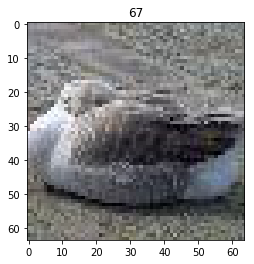

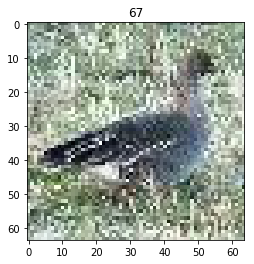

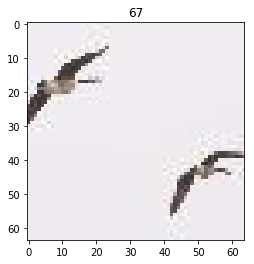

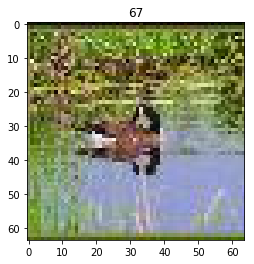

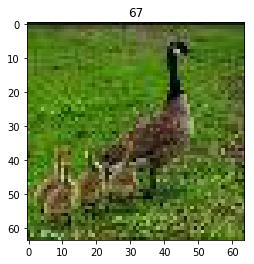

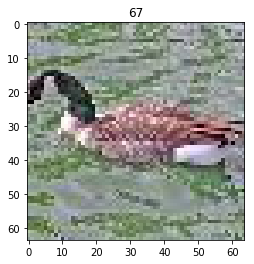

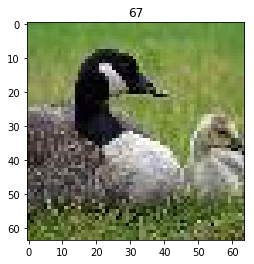

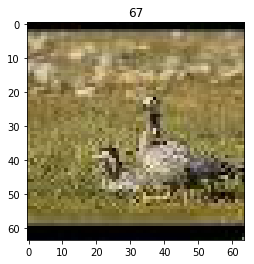

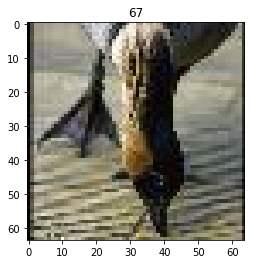

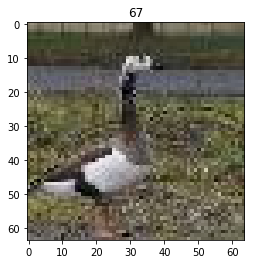

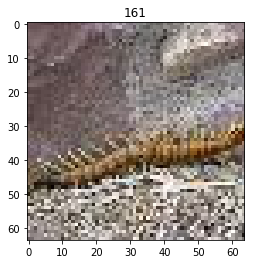

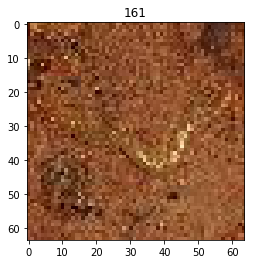

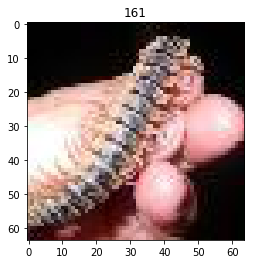

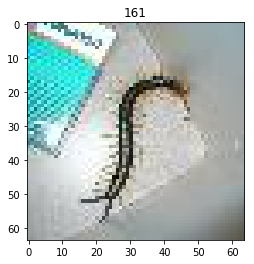

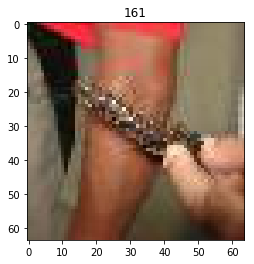

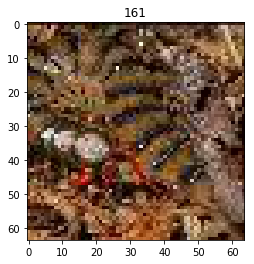

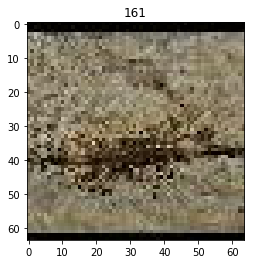

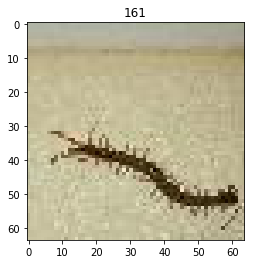

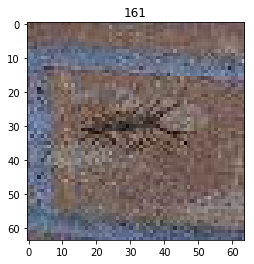

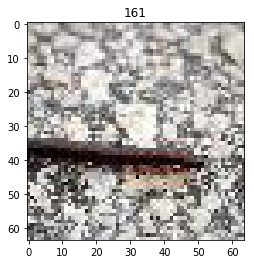

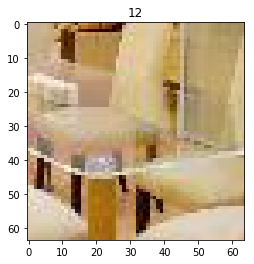

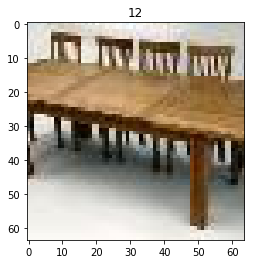

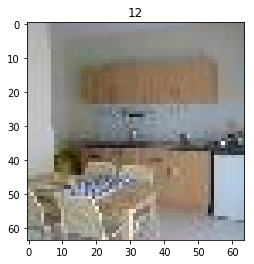

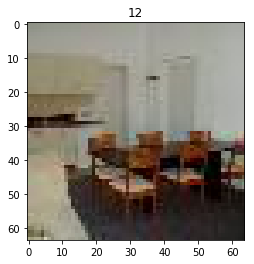

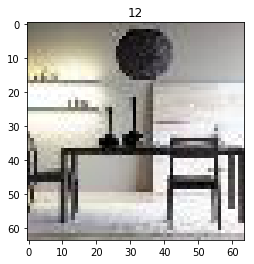

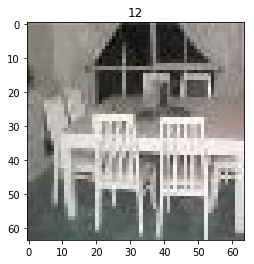

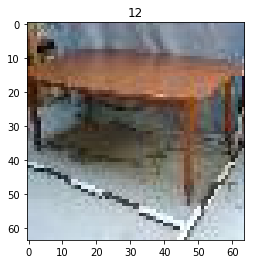

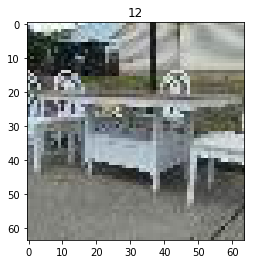

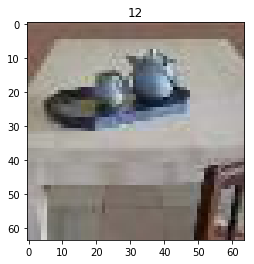

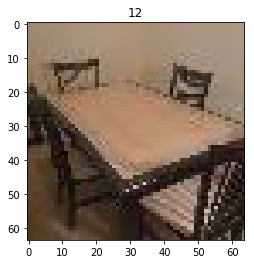

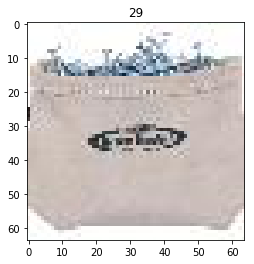

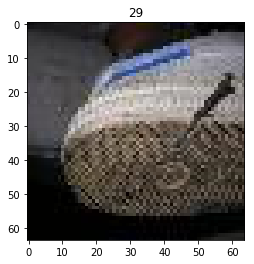

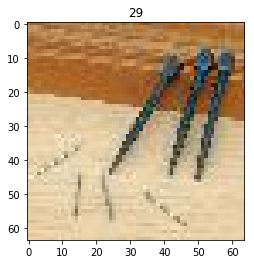

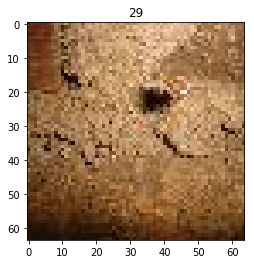

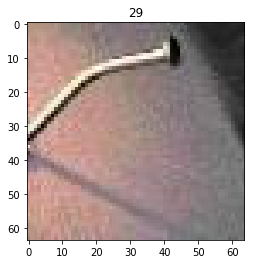

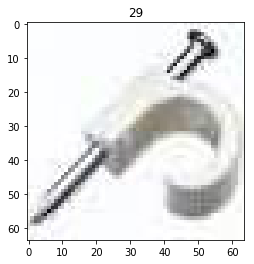

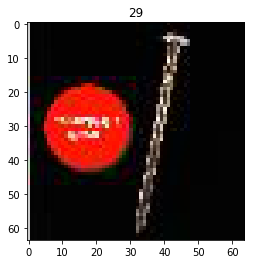

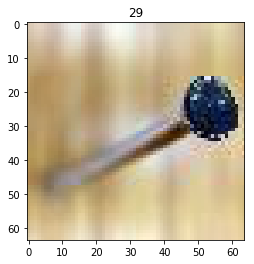

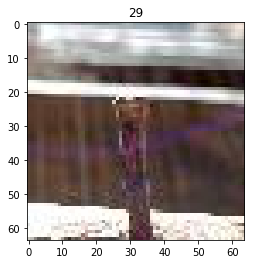

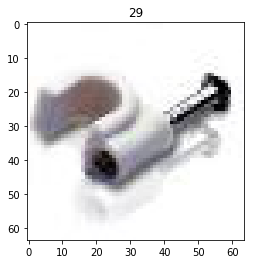

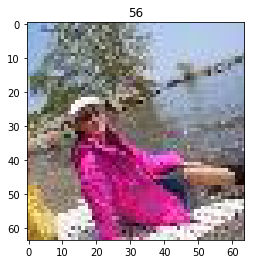

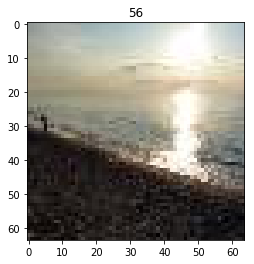

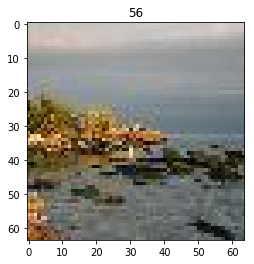

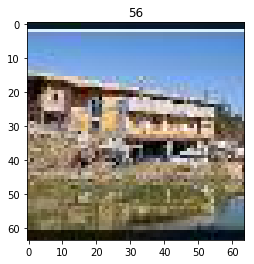

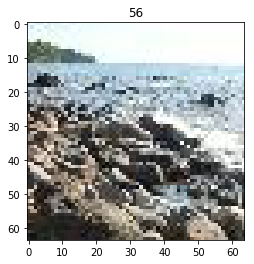

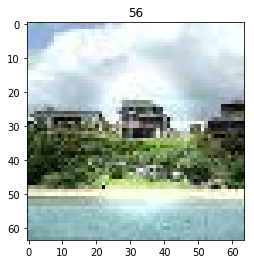

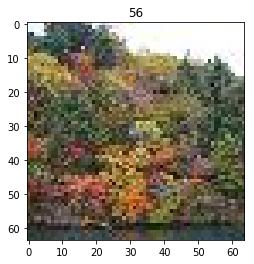

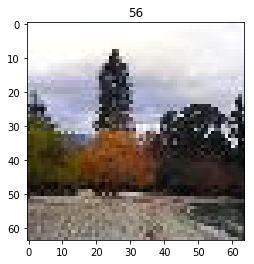

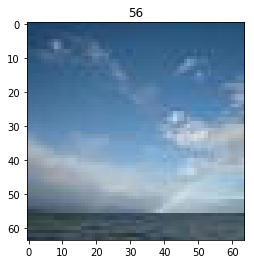

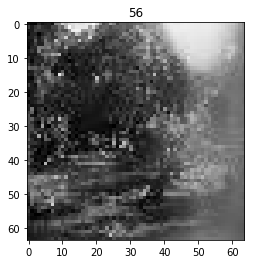

In [24]:
for f in test_filenames:
    images, labels = read_from_tfrecords(f)
    print(f)
    print(len(labels))
    for im, lab in zip(images[:10], labels[:10]):
        plt.figure()
        plt.imshow(im)
        plt.title(lab)
    print("*"*100)